In [1]:
# Fichero del modelo de clasificacion

# Importamos las librerias a utilizar en el problema de clasificacion
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
#Punto 6.b: convertir el problema de regresion en clasificacion
# Carga de datos y filtrado inicial
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")
columns_of_interest = [col for col in wind_ava.columns if '.13' in col] + ['energy']
wind_ava_filtered = wind_ava[columns_of_interest].copy()

# Cálculo del tercer cuantil y etiquetado de las instancias
tercer_cuantil = wind_ava_filtered['energy'].quantile(0.75)
wind_ava_filtered['class'] = np.where(wind_ava_filtered['energy'] < tercer_cuantil, 0, 1)


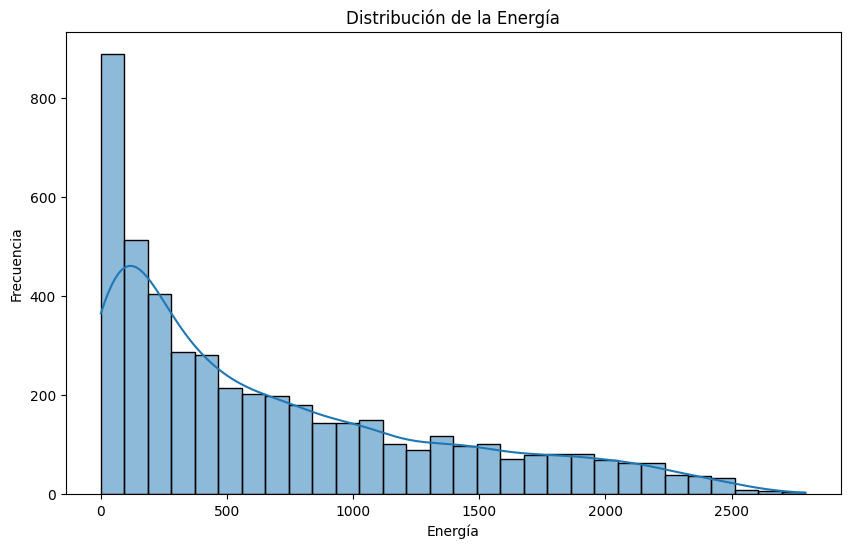

In [3]:
# Visualización de la distribución de la energía
plt.figure(figsize=(10, 6))
sns.histplot(wind_ava_filtered['energy'], bins=30, kde=True)
plt.title('Distribución de la Energía')
plt.xlabel('Energía')
plt.ylabel('Frecuencia')
plt.show()

In [4]:
# Preparación de los datos para el modelo
X = wind_ava_filtered.drop(['energy', 'class'], axis=1)
y = wind_ava_filtered['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100432070, shuffle=True, stratify=y)

# Ajuste de 'scale_pos_weight' para manejar el desbalance de clases
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Inicialización del pipeline con SMOTE y XGBoost
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=100432070)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])

In [5]:
# Ajuste de Hiperparámetros
param_grid = {
    'smote__k_neighbors': [2, 5],
    'xgb__max_depth': [6, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__n_estimators': [650, 1000],
    'xgb__gamma': [0.4, 0.5],
    'xgb__min_child_weight': [0, 1],
    'xgb__subsample': [0.2, 0.3],
    'xgb__colsample_bytree': [0.9, 1],
    'xgb__scale_pos_weight': [1, scale_pos_weight] 
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='balanced_accuracy',  # Usamos balanced_accuracy
    verbose=2,
    n_jobs=-1
)

# Ejecución de GridSearchCV para encontrar los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Utilización del mejor modelo con los hiperparámetros encontrados
model_optimizado = grid_search.best_estimator_

# Predicciones y evaluación del modelo optimizado
y_pred_optimizado = model_optimizado.predict(X_test)

print("\nBalanced Accuracy del modelo optimizado en el conjunto de prueba:",
      balanced_accuracy_score(y_test, y_pred_optimizado))
print(classification_report(y_test, y_pred_optimizado))

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Mejores hiperparámetros encontrados:
smote__k_neighbors: 2
xgb__colsample_bytree: 1
xgb__gamma: 0.4
xgb__learning_rate: 0.01
xgb__max_depth: 6
xgb__min_child_weight: 1
xgb__n_estimators: 650
xgb__scale_pos_weight: 1
xgb__subsample: 0.2

Balanced Accuracy del modelo optimizado en el conjunto de prueba: 0.8392368649587494
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1175
           1       0.70      0.79      0.74       392

    accuracy                           0.86      1567
   macro avg       0.81      0.84      0.82      1567
weighted avg       0.87      0.86      0.86      1567



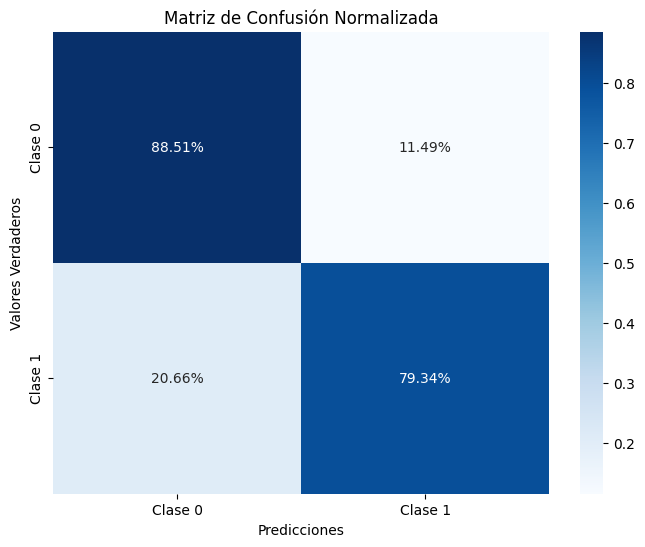

In [6]:
# Matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred_optimizado)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Visualizaciónde la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión Normalizada')
plt.show()

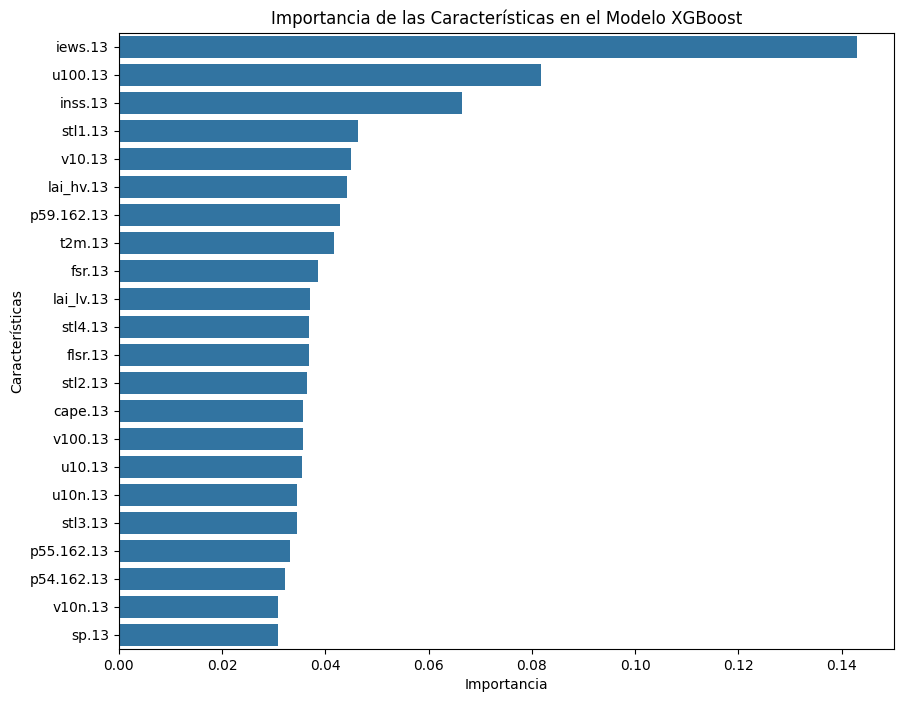

In [7]:
# Importancia de las características
feature_importances = model_optimizado.named_steps['xgb'].feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Gráfico de barras de las importancias
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Features')
plt.title('Importancia de las Características en el Modelo XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# La caracteristica mas importante sería  el Instantaneous Eastward Turbulent Surface Stress: Refiere al estrés 
# superficial turbulento hacia el este medido en un instante específico. 
# Este estrés es una medida de la fuerza que el viento ejerce en la superficie de la Tierra en la dirección este-oeste.